In [1]:
from __future__ import division
import datetime
import matplotlib.pyplot as plt
import cPickle as pickle
import numpy as np
import v2gsim 
import pandas 


# ### Require gurobi or CPLEX #####
# Create a project and initialize it with someitineraries
project = v2gsim.model.Project()
project = v2gsim.itinerary.from_excel(project, '../data/NHTS/Tennessee.xlsx')
project = v2gsim.itinerary.copy_append(project, nb_of_days_to_add=2)

# This function from the itinerary module return all the vehicles that
# start and end their day at the same location (e.g. home)
project.vehicles = v2gsim.itinerary.get_cycling_itineraries(project)


# Reduce the number of vehicles
project.vehicles = project.vehicles[0:100]


In [2]:
# Create some new charging infrastructures, append those new
# infrastructures to the project list of infrastructures
charging_stations = []
charging_stations.append(
    v2gsim.model.ChargingStation(name='L2', maximum_power=7200, minimum_power=0))
charging_stations.append(
    v2gsim.model.ChargingStation(name='L1_V1G', maximum_power=1400, minimum_power=0, post_simulation=True))
charging_stations.append(
    v2gsim.model.ChargingStation(name='L2_V2G', maximum_power=7200, minimum_power=-7200, post_simulation=True))
project.charging_stations.extend(charging_stations)

 #Create a data frame with the new infrastructures mix and
# apply this mix at all the locations
df = pandas.DataFrame(index=['L2', 'L1_V1G', 'L2_V2G'],
                      data={'charging_station': charging_stations,
                            'probability': [0.0, 0.4, 0.6]})
for location in project.locations:
    if location.category in ['Work', 'Home']:
        location.available_charging_station = df.copy()

# Initiate SOC and charging infrastructures
v2gsim.core.initialize_SOC(project, nb_iteration=2)

# Assign a basic result function to save power demand
for vehicle in project.vehicles:
    vehicle.result_function = v2gsim.post_simulation.netload_optimization.save_vehicle_state_for_optimization


# Launch the simulation
v2gsim.core.run(project, date_from=project.date + datetime.timedelta(days=1),
                date_to=project.date + datetime.timedelta(days=2),
                reset_charging_station=False)


core.initialize_SOC: 100%|####################################################|
core.run:   8%|#####                                                          |       mean  mean_rate       std  std_rate
0  0.950000   0.000000  0.000000  0.000000
1  0.918388   0.031612  0.115594 -0.115594
2  0.918468  -0.000080  0.115588  0.000007

core.run: 100%|###############################################################|core.run: 100%|###############################################################|


In [3]:
# Look at the results
total_power_demand = v2gsim.post_simulation.result.total_power_demand(project)

# Optimization
myopti = v2gsim.post_simulation.netload_optimization.CentralOptimization(project, 10,
                                                                         project.date + datetime.timedelta(days=1),
                                                                         project.date + datetime.timedelta(days=2),
                                                                         minimum_SOC=0.1, maximum_SOC=0.95)

In [33]:
finalResult = pandas.DataFrame()
filename = '../data/netload/2025.pickle'
# with open(filename, 'rb') as fp:
#     net_load = pickle.load(fp)
net_load=pandas.read_pickle(filename)
day = datetime.datetime(2025, 7, 17)
net_load = pandas.DataFrame(net_load[day: day + datetime.timedelta(days=1)]['netload'])
net_load.head()

,netload
2025-07-17 00:00:00,34286.302433
2025-07-17 00:05:00,33891.544788
2025-07-17 00:10:00,33501.846918
2025-07-17 00:15:00,33173.429482
2025-07-17 00:20:00,32810.496028


In [92]:
load[0]['demand（MW）']

KeyError: 0

In [106]:
finalResult = pandas.DataFrame()
filename = '../data/netload/CAISO1819.csv'
load=pandas.read_csv(filename)
day = datetime.datetime(2018, 7, 2)

load['date_time'] = [datetime.datetime.strptime(x,"%m/%d/%Y %H:%M") for x in load['date_time']]
load=load.set_index(load['date_time'])
load=load.drop(columns='date_time')

load = pandas.DataFrame(load[day: day + datetime.timedelta(days=2)]['demand (MW)'])

In [107]:
load.head()

,demand (MW)
date_time,
2018-07-02 00:00:00,31187
2018-07-02 01:00:00,32303
2018-07-02 02:00:00,32870
2018-07-02 03:00:00,32478
2018-07-02 04:00:00,31983


In [5]:
myresult = myopti.solve(project, net_load * 1000000,1500000, price=pr,
                        peak_shaving='economic', SOC_margin=0.05)

There is 96 vehicle participating in the optimization (96.0%)
There is 4 unfeasible vehicle.

Solver script file: 'c:\users\meiye'~1\appdata\local\temp\tmpwbnrqm.gurobi.script'
Solver log file: 'c:\users\meiye'~1\appdata\local\temp\tmpditkd8.gurobi.log'
Solver solution file: 'c:\users\meiye'~1\appdata\local\temp\tmpdbz_wz.gurobi.txt'
Solver problem files: ("c:\\users\\meiye'~1\\appdata\\local\\temp\\tmpb8edug.pyomo.lp",)
Academic license - for non-commercial use only
Read LP format model from file c:\users\meiye'~1\appdata\local\temp\tmpb8edug.pyomo.lp
Reading time = 11.94 seconds
x41473: 83041 rows, 41473 columns, 6110209 nonzeros
Optimize a model with 83041 rows, 41473 columns and 6110209 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [3e+00, 4e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 3e+05]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 4497 rows and 14217 columns (preso

In [13]:
temp_vehicle = pandas.DataFrame(
    (total_power_demand['total'] - myresult['vehicle_before'] + myresult['vehicle_after']) *
    (1500000 / len(project.vehicles)) / (1000 * 1000))  # Scale up and W to MW
temp_vehicle = temp_vehicle.rename(columns={0: 'vehicle'})
temp_vehicle['index'] = range(0, len(temp_vehicle))
temp_vehicle = temp_vehicle.set_index(['index'], drop=True)


2020-07-10 00:00:00    28640.0
2020-07-10 00:01:00    28640.0
2020-07-10 00:02:00    28640.0
2020-07-10 00:03:00    28640.0
2020-07-10 00:04:00    28640.0
2020-07-10 00:05:00    28640.0
2020-07-10 00:06:00    28640.0
2020-07-10 00:07:00    28640.0
2020-07-10 00:08:00    28640.0
2020-07-10 00:09:00    27240.0
2020-07-10 00:10:00    27240.0
2020-07-10 00:11:00    27240.0
2020-07-10 00:12:00    27240.0
2020-07-10 00:13:00    27240.0
2020-07-10 00:14:00    27240.0
2020-07-10 00:15:00    25800.0
2020-07-10 00:16:00    25800.0
2020-07-10 00:17:00    25800.0
2020-07-10 00:18:00    25800.0
2020-07-10 00:19:00    25800.0
2020-07-10 00:20:00    25800.0
2020-07-10 00:21:00    25800.0
2020-07-10 00:22:00    25800.0
2020-07-10 00:23:00    25800.0
2020-07-10 00:24:00    25800.0
2020-07-10 00:25:00    25800.0
2020-07-10 00:26:00    25800.0
2020-07-10 00:27:00    25800.0
2020-07-10 00:28:00    25800.0
2020-07-10 00:29:00    25800.0
                        ...   
2020-07-10 23:30:00    30000.0
2020-07-

In [14]:
temp_netload = net_load.copy()
temp_netload = temp_netload.resample('60S')
temp_netload = temp_netload.fillna(method='ffill').fillna(method='bfill')
temp_netload = temp_netload.head(len(temp_vehicle))
tempIndex = temp_netload.index
temp_netload['index'] = range(0, len(temp_vehicle))
temp_netload = temp_netload.set_index(['index'], drop=True)
temp_netload.head()

,netload
index,
0,25824.481159
1,25824.481159
2,25824.481159
3,25824.481159
4,25824.481159


In [11]:
temp_result = pandas.DataFrame(temp_netload['netload'] + temp_vehicle['vehicle'])
temp_result = temp_result.rename(columns={0: 'netload'})
temp_result = temp_result.set_index(tempIndex)
temp_netload = temp_netload.set_index(tempIndex)
temp_vehicle = temp_vehicle.set_index(tempIndex)

temp_result.head()


,netload
2025-06-17 00:00:00,22574.802951
2025-06-17 00:01:00,22574.802951
2025-06-17 00:02:00,22574.802951
2025-06-17 00:03:00,22574.802951
2025-06-17 00:04:00,22574.802951


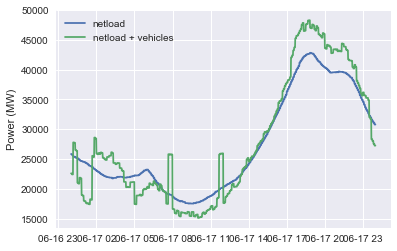

In [9]:
plt.plot(temp_netload['netload'], label='netload')
plt.plot(temp_result['netload'], label='netload + vehicles')
plt.ylabel('Power (MW)')
plt.legend()
plt.show()

In [18]:
temp_vehicle_demand = pandas.DataFrame(
    (myresult['vehicle_after_demand']) *    (1500000 / len(project.vehicles)) / (1000 * 1000))  # Scale up and W to MW
temp_vehicle_demand = temp_vehicle_demand.set_index(tempIndex)
 

temp_vehicle_generation = pandas.DataFrame(
    (-myresult['vehicle_after_generation']) *    (1500000 / len(project.vehicles)) / (1000 * 1000))  # Scale up and W to MW
temp_vehicle_generation = temp_vehicle_generation.set_index(tempIndex)
# temp_vehicle_generation.head()

,vehicle_after_demand
2025-06-17 00:00:00,1650.421297
2025-06-17 00:01:00,1650.421297
2025-06-17 00:02:00,1650.421297
2025-06-17 00:03:00,1650.421297
2025-06-17 00:04:00,1650.421297
